# Import

In [1]:
import pandas as pd
from pathlib import Path
import torch
from torch import nn
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Part 1 / classification : presence of epigenetic mark in sequence

In [2]:
data_dir = Path("..") / "H3K4me3"

data_train = pd.read_csv(data_dir / "train.csv")
data_val = pd.read_csv(data_dir / "dev.csv")
data_test = pd.read_csv(data_dir / "test.csv")

In [3]:
data_train

,sequence,label
0,CCATGGATTCGCAGTGCCCAAACCTCATATTCACAGGATTACGTCG...,1
1,AACTTGCCCAAATGATAATGTACATCAAAGTTTGACTAGAAGTCCA...,0
2,CCACTGGTAAAGCTCTTCTTTTCAAGAGTTCGTCTAATACCTCACT...,0
3,GGGGTGCTTTATTTTGGTTGTTCTCTTGTGCTTTCTACGTTTATGT...,0
4,CTTCCTTCTTCACAATTTTTGTAAGACAATCCATCACGCCCGTGTA...,0
...,...,...
29434,TGGCTTTCACATTTGGTCCGATTCTCGCTCTTTAAATTTTTTGCCC...,1
29435,AGCTGCTTCAATATTATTCGACCACTCAAGAAAGATATCCAGATTC...,0
29436,AGGTTATTTATTCTACTACACGCAGTTTTTTTTTTTCAATGGGTTA...,1
29437,ATCATACCTAGATCTGCTTCTTCTGGAGTGACTCTGTTAGTACCGA...,0


In [ ]:
def one_hot_encoding(sequence, max_length):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1]}

    encoded_sequence = []
    for i in range(max_length):
        if i < len(sequence):
            encoded_sequence.append(mapping.get(sequence[i], [0, 0, 0, 0]))  
        else:
            encoded_sequence.append([0, 0, 0, 0]) 

    return np.array(encoded_sequence)

max_len = max(
    max(len(s) for s in data_train["sequence"]),
    max(len(s) for s in data_val["sequence"]),
    max(len(s) for s in data_test["sequence"]),
)
X_train = np.array([one_hot_encoding(seq, max_len) for seq in data_train["sequence"]])
y_train = data_train["label"]

X_val = np.array([one_hot_encoding(seq, max_len) for seq in data_val["sequence"]])
y_val = data_val["label"]

X_test = np.array([one_hot_encoding(seq, max_len) for seq in data_test["sequence"]])
y_test = data_test["label"]


In [5]:
X_train_t = torch.tensor(X_train).permute(0,2,1) # (N,4,L)
X_val_t = torch.tensor(X_val).permute(0,2,1)
X_test_t = torch.tensor(X_test).permute(0,2,1)

y_train_t = torch.tensor(y_train).unsqueeze(1)
y_val_t = torch.tensor(y_val).unsqueeze(1)
y_test_t = torch.tensor(y_test).unsqueeze(1)

In [6]:
class CNN(nn.Module):
    def __init__(self, in_channels = 4, n_classes = 1, dropout = 0.2):
        super(CNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv1d(in_channels, 32, kernel_size = 3, padding = 1),
            nn.BatchNorm1d(32),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size = 2),
            
            nn.Conv1d(32, 64, kernel_size = 3, padding = 1),
            nn.BatchNorm1d(64),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size = 2),
            
            nn.Conv1d(64, 128, kernel_size = 3, padding = 1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
        )
        self.pool = nn.AdaptiveAvgPool1d(1)
        
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(128, n_classes),
        )
    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.head(x)
        return x    
    

In [7]:
train_ds = TensorDataset(X_train_t, y_train_t)
val_ds = TensorDataset(X_val_t, y_val_t)
test_ds = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size = 64, shuffle = True)
val_loader = DataLoader(val_ds, batch_size = 64, shuffle = False)
test_loader = DataLoader(test_ds, batch_size = 64, shuffle = False)

In [8]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0, mode="min"):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.best = None
        self.count = 0

    def step(self, metric):
        if self.best is None:
            self.best = metric
            return False  

        improved = (metric < self.best - self.min_delta) if self.mode == "min" else (metric > self.best + self.min_delta)

        if improved:
            self.best = metric
            self.count = 0
            return False
        else:
            self.count += 1
            return self.count >= self.patience


In [9]:

import tqdm 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for x, y in train_loader:
        x = x.to(device).float()
        y = y.to(device).float()

        optimizer.zero_grad()
        logits = model(x)                    # (B, 1)
        loss_val = criterion(logits, y)      

        loss_val.backward()
        optimizer.step()

        running_loss += loss_val.item() * x.size(0)

        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).float()
        correct += (preds == y).sum().item()
        total += y.numel()

    return running_loss / len(train_loader.dataset), correct / total


@torch.no_grad()
def evaluate(model, loader, criterion, device, desc="eval"):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0

    for x, y in loader:
        x = x.to(device).float()
        y = y.to(device).float()

        logits = model(x)
        loss_val = criterion(logits, y)

        running_loss += loss_val.item() * x.size(0)

        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).float()
        correct += (preds == y).sum().item()
        total += y.numel()

    return running_loss / len(loader.dataset), correct / total




def fit(model, train_loader, val_loader, optimizer, criterion, device,
        epochs=20, patience=5, min_delta=0.0, save_path="best_cnn.pt"):

    es = EarlyStopping(patience=patience, min_delta=min_delta, mode="min")
    train_losses, val_losses = [], []
    for epoch in range(1, epochs + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        va_loss, va_acc = evaluate(model, val_loader, criterion, device, desc="val")

        print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | val loss {va_loss:.4f} acc {va_acc:.3f}")

        # save best
        if es.best is None or va_loss < es.best - min_delta:
            torch.save(model.state_dict(), save_path)

        # early stop
        if es.step(va_loss):
            print(f"Early stopping at epoch {epoch} (best val loss: {es.best:.4f})")
            break
        train_losses.append(tr_loss)
        val_losses.append(va_loss)
    # reload best weights
    model.load_state_dict(torch.load(save_path, map_location=device))
    return model, train_losses, val_losses


@torch.no_grad()
def test_model(model, test_loader, criterion, device):
    test_loss, test_acc = evaluate(model, test_loader, criterion, device, desc="test")

    all_probs, all_y = [], []
    model.eval()
    for x, y in test_loader:
        x = x.to(device).float()
        y = y.to(device).float()
        logits = model(x)
        probs = torch.sigmoid(logits)
        all_probs.append(probs.detach().cpu())
        all_y.append(y.detach().cpu())

    all_probs = torch.cat(all_probs, dim=0).numpy().reshape(-1)
    all_y = torch.cat(all_y, dim=0).numpy().reshape(-1)

    return test_loss, test_acc, all_probs, all_y


In [10]:
model = CNN(in_channels=4, n_classes=1, dropout=0.2).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()

model, train_loss, val_loss = fit(model, train_loader, val_loader, optimizer, criterion, device,
            epochs=40, patience=10, min_delta=1e-4, save_path="best_cnn.pt")

test_loss, test_acc, probs, y_true = test_model(model, test_loader, criterion, device)
print(f"TEST | loss {test_loss:.4f} acc {test_acc:.3f}")


Epoch 01 | train loss 0.6737 acc 0.583 | val loss 0.6650 acc 0.598
Epoch 02 | train loss 0.6655 acc 0.598 | val loss 0.6625 acc 0.609
Epoch 03 | train loss 0.6633 acc 0.604 | val loss 0.6652 acc 0.600
Epoch 04 | train loss 0.6630 acc 0.604 | val loss 0.6724 acc 0.586
Epoch 05 | train loss 0.6607 acc 0.609 | val loss 0.6676 acc 0.601
Epoch 06 | train loss 0.6590 acc 0.608 | val loss 0.6634 acc 0.602
Epoch 07 | train loss 0.6590 acc 0.608 | val loss 0.6597 acc 0.609
Epoch 08 | train loss 0.6575 acc 0.611 | val loss 0.6653 acc 0.606
Epoch 09 | train loss 0.6584 acc 0.613 | val loss 0.6649 acc 0.605
Epoch 10 | train loss 0.6557 acc 0.615 | val loss 0.6666 acc 0.598
Epoch 11 | train loss 0.6558 acc 0.614 | val loss 0.6559 acc 0.618
Epoch 12 | train loss 0.6548 acc 0.614 | val loss 0.6624 acc 0.607
Epoch 13 | train loss 0.6534 acc 0.618 | val loss 0.6658 acc 0.601
Epoch 14 | train loss 0.6539 acc 0.616 | val loss 0.6588 acc 0.605
Epoch 15 | train loss 0.6532 acc 0.618 | val loss 0.6595 acc 0

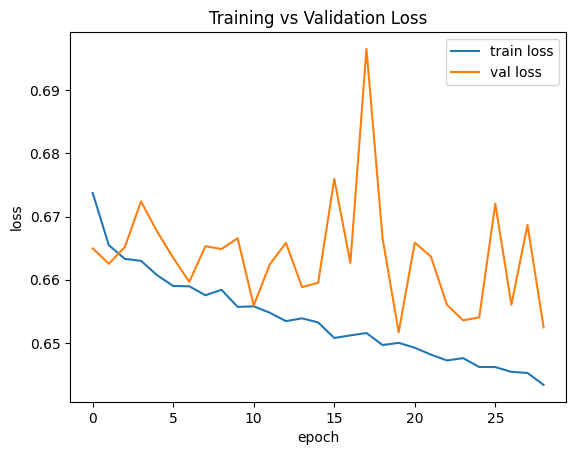

In [11]:
def plot_losses(train_loss, val_loss):
    plt.figure()
    plt.plot(train_loss, label="train loss")
    plt.plot(val_loss, label="val loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.show()
    
plot_losses(train_loss, val_loss)

In [48]:
def plot_roc_pr(y_true, y_proba, name="model"):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC curve - {name}")
    plt.tight_layout()
    # plt.savefig(FIG_DIR / f"roc_{name}.png", dpi=200)
    plt.show()

    prec, rec, _ = precision_recall_curve(y_true, y_proba)
    plt.figure(figsize=(5,4))
    plt.plot(rec, prec)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"PR curve - {name}")
    plt.tight_layout()
    # plt.savefig(FIG_DIR / f"pr_{name}.png", dpi=200)
    plt.show()

def show_confusion(y_true, y_proba, threshold=0.5, name="model"):
    y_pred = (y_proba >= threshold).astype(int)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, values_format="d")
    plt.title(f"Confusion matrix - {name} : thr={threshold:.2f}")
    plt.tight_layout()
    # plt.savefig(FIG_DIR / f"cm_{name}_thr_{threshold:.2f}.png", dpi=200)
    plt.show()

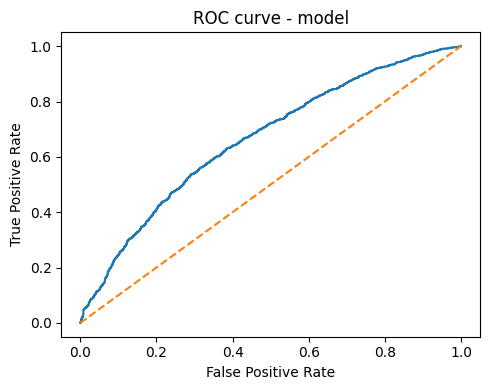

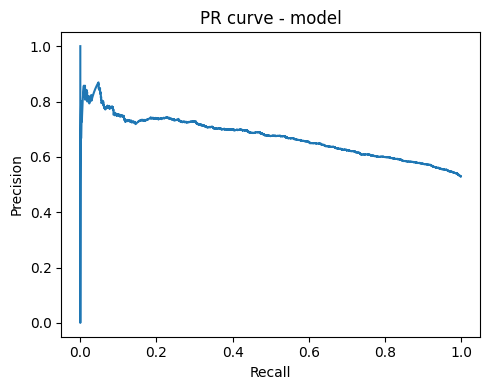

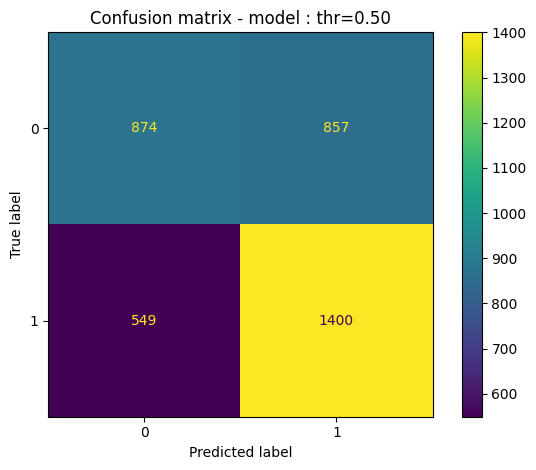

In [49]:
plot_roc_pr(y_true, probs)
show_confusion(y_true, probs)


In [12]:

def plot_first_layer_filters(model, conv_name="features.0", max_filters=16):
   
    conv = dict(model.named_modules())[conv_name]
    W = conv.weight.detach().cpu().numpy()  # (F, 4, K)

    bases = ["A", "C", "G", "T"]
    F, C, K = W.shape
    n_show = min(F, max_filters)

    for f in range(n_show):
        w = W[f]  # (4, K)

        w_norm = (w - w.mean()) / (w.std() + 1e-8)

        plt.figure(figsize=(K*0.8, 2.2))
        plt.imshow(w_norm, aspect="auto")
        plt.yticks(range(4), bases)
        plt.xticks(range(K), range(1, K+1))
        plt.colorbar(label="weight (z-score)")
        plt.title(f"Filter {f} (Conv1d weights)")

        consensus = "".join([bases[i] for i in np.argmax(w, axis=0)])
        plt.xlabel(f"Position  | consensus ≈ {consensus}")
        plt.tight_layout()
        plt.show()


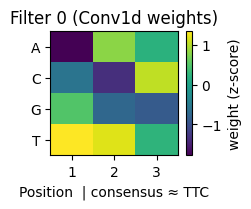

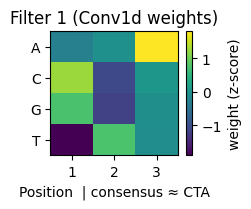

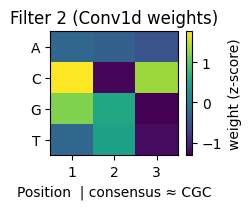

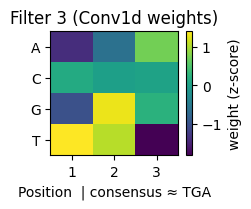

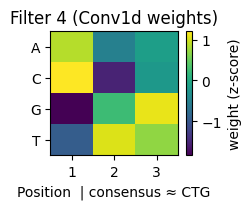

In [14]:
plot_first_layer_filters(model, conv_name="features.0", max_filters=5)


# Part 2 / prediction of following nucleotide

In [ ]:
from Bio import SeqIO

out_dir = Path("..")
genome = ""
for record in SeqIO.parse(out_dir / "GCA_000146045.2_R64_genomic.fna", "fasta"):
    genome += str(record.seq).upper()

genome = genome.replace("N", "")
print(f"Longueur totale du génome : {len(genome)}")

def split_genome(genome, segment_length=512):
    sequences = []
    for i in range(0, len(genome), segment_length):
        seq = genome[i:i+segment_length]
        if len(seq) == segment_length:
            sequences.append(seq)
    return sequences

sequences = split_genome(genome, segment_length=512)
print(f"Nombre de séquences générées : {len(sequences)}")

X = [seq[:-1] for seq in sequences] 
y = [seq[-1] for seq in sequences]  

Longueur totale du génome : 12071326
Nombre de séquences générées : 23576


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
print(Counter(y))

labels = ['T', 'A', 'C', 'G']
counts = [7403, 7140, 4564, 4469]

class_weights = compute_class_weight(
    class_weight='balanced',  
    classes=np.array([0, 1, 2, 3]), 
    y=np.repeat([0, 1, 2, 3], counts)
)

class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print(class_weights_dict)

def one_hot_encode(sequence, length):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1]}
    encoded = np.zeros((length, 4)) 
    for i, nuc in enumerate(sequence):
        encoded[i] = mapping.get(nuc, [0, 0, 0, 0]) 
    return encoded

X_encoded = np.array([one_hot_encode(seq, 511) for seq in X])

y_to_id = {'A':0, 'C':1, 'G':2, 'T':3}
y_ids = np.array([y_to_id[n] for n in y], dtype=np.int64) 

Counter({'T': 7403, 'A': 7140, 'C': 4564, 'G': 4469})
{0: np.float64(0.7961637174118601), 1: np.float64(0.8254901960784313), 2: np.float64(1.2914110429447854), 3: np.float64(1.318863280375923)}


In [17]:
class CNN_LM(nn.Module):
    def __init__(self,in_channels = 4, out_classes = 4, dropout = 0.2):
        super(CNN_LM, self).__init__()
        self.backbone = nn.Sequential(
            nn.Conv1d(in_channels, 32, kernel_size = 3, padding = 1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size = 2),
            
            nn.Conv1d(32, 64, kernel_size = 3, padding = 1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size = 2),
            
            nn.Conv1d(64, 128, kernel_size = 3, padding = 1),
            nn.BatchNorm1d(128),
            nn.ReLU(), 
        )
        
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(128, out_classes),
        )
        
    def forward(self,x):
        x = self.backbone(x)
        x = self.pool(x)
        x = self.head(x)
        return x
        
        
        

In [26]:
X_temp, X_test, y_temp , y_test = train_test_split(X_encoded, y_ids, test_size = 0.1, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, train_size = 0.2, random_state = 42)

X_train_t = torch.tensor(X_train).permute(0,2,1) # (N,4,L)
X_val_t = torch.tensor(X_val).permute(0,2,1)
X_test_t = torch.tensor(X_test).permute(0,2,1)

y_train_t = torch.tensor(y_train)
y_val_t = torch.tensor(y_val)
y_test_t = torch.tensor(y_test)

In [27]:
train_ds = TensorDataset(X_train_t, y_train_t)
val_ds = TensorDataset(X_val_t, y_val_t)
test_ds = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size = 64, shuffle = True)
val_loader = DataLoader(val_ds, batch_size = 64, shuffle = False)
test_loader = DataLoader(test_ds, batch_size = 64, shuffle = False)

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_one_epoch_part2(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for x, y in train_loader:
        x = x.to(device).float()
        y = y.to(device).long()   # (B,)

        optimizer.zero_grad()
        logits = model(x)                    # (B, 1)
        loss_val = criterion(logits, y)      

        loss_val.backward()
        optimizer.step()

        running_loss += loss_val.item() * x.size(0)

        preds = torch.argmax(logits, dim = 1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return running_loss / len(train_loader.dataset), correct / total


@torch.no_grad()
def evaluate_part2(model, loader, criterion, device, desc="eval"):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0

    for x, y in loader:
        x = x.to(device).float()
        y = y.to(device).long()   # (B,)

        logits = model(x)
        loss_val = criterion(logits, y)

        running_loss += loss_val.item() * x.size(0)

        preds = torch.argmax(logits, dim = 1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return running_loss / len(loader.dataset), correct / total


def fit_part2(model, train_loader, val_loader, optimizer, criterion, device,
        epochs=20, patience=5, min_delta=0.0, save_path="best_cnn_part2.pt"):

    es = EarlyStopping(patience=patience, min_delta=min_delta, mode="min")
    train_losses, val_losses = [], []
    for epoch in range(1, epochs + 1):
        tr_loss, tr_acc = train_one_epoch_part2(model, train_loader, optimizer, criterion, device)
        va_loss, va_acc = evaluate_part2(model, val_loader, criterion, device, desc="val")

        print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | val loss {va_loss:.4f} acc {va_acc:.3f}")

        # save best
        if es.best is None or va_loss < es.best - min_delta:
            torch.save(model.state_dict(), save_path)

        # early stop
        if es.step(va_loss):
            print(f"Early stopping at epoch {epoch} (best val loss: {es.best:.4f})")
            break
        train_losses.append(tr_loss)
        val_losses.append(va_loss)
    # reload best weights
    model.load_state_dict(torch.load(save_path, map_location=device))
    return model, train_losses, val_losses


@torch.no_grad()
def test_model_part2(model, test_loader, criterion, device):

    running_loss = 0.0
    correct, total = 0, 0

    all_probs, all_y = [], []
    for x, y in test_loader:
        x = x.to(device).float()
        y = y.to(device).long()   # (B,)
        logits = model(x)
        probs = torch.softmax(logits, dim=1)
        preds = probs.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

        all_probs.append(probs.cpu())
        all_y.append(y.cpu())

    test_loss = running_loss / len(test_loader.dataset)
    test_acc = correct / total

    y_true = torch.cat(all_y, dim=0).numpy()        # (N,)
    y_proba = torch.cat(all_probs, dim=0).numpy()   # (N,4)


    return test_loss, test_acc, y_true, y_proba

In [38]:
model = CNN_LM(in_channels=4, out_classes=4, dropout=0.3).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
weights = np.array([class_weights_dict[i] for i in range(4)], dtype=np.float32)  
class_weights_t = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights_t)

model, train_losses, val_losses = fit_part2(
    model, train_loader, val_loader, optimizer, criterion, device,
    epochs=20, patience=5, min_delta=1e-4
)

test_loss, test_acc, y_true, y_proba = test_model_part2(model, test_loader, criterion, device)
print(f"TEST | loss {test_loss:.4f} acc {test_acc:.3f}")


Epoch 01 | train loss 1.3823 acc 0.270 | val loss 1.3495 acc 0.310
Epoch 02 | train loss 1.3409 acc 0.320 | val loss 1.3328 acc 0.310
Epoch 03 | train loss 1.3267 acc 0.325 | val loss 1.3301 acc 0.310
Epoch 04 | train loss 1.3227 acc 0.326 | val loss 1.3300 acc 0.310
Epoch 05 | train loss 1.3224 acc 0.324 | val loss 1.3292 acc 0.310
Epoch 06 | train loss 1.3195 acc 0.325 | val loss 1.3295 acc 0.310
Epoch 07 | train loss 1.3198 acc 0.324 | val loss 1.3295 acc 0.310
Epoch 08 | train loss 1.3185 acc 0.325 | val loss 1.3296 acc 0.310
Epoch 09 | train loss 1.3161 acc 0.324 | val loss 1.3298 acc 0.310
Epoch 10 | train loss 1.3178 acc 0.327 | val loss 1.3301 acc 0.310
Early stopping at epoch 10 (best val loss: 1.3292)
TEST | loss 0.0000 acc 0.325


# Part 3 / fine-tune model of part 2 on task of part 1

In [15]:
class model_finetune(nn.Module):
    def __init__(self,n_classes, pretrained_path, dropout, freeze_backbone):
        super(model_finetune, self).__init__()
        base = CNN_LM(in_channels=4, out_classes=4, dropout=dropout)

        state = torch.load(pretrained_path, map_location=device)
        base.load_state_dict(state)

        self.backbone = base.backbone
        self.pool = base.pool
        
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(128, n_classes),
        )
        
        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False
            for p in self.pool.parameters():
                p.requires_grad = False
                
    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x)
        x = self.head(x)
        return x 
        

In [18]:
model = model_finetune(n_classes=1, dropout=0.2, pretrained_path= "best_cnn_part2.pt", freeze_backbone=False).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()

model, train_loss, val_loss = fit(model, train_loader, val_loader, optimizer, criterion, device,
            epochs=40, patience=10, min_delta=1e-4, save_path="best_cnn.pt")

test_loss, test_acc, probs, y_true = test_model(model, test_loader, criterion, device)
print(f"TEST | loss {test_loss:.4f} acc {test_acc:.3f}")

Epoch 01 | train loss 0.6689 acc 0.595 | val loss 0.6640 acc 0.598
Epoch 02 | train loss 0.6596 acc 0.610 | val loss 0.6612 acc 0.607
Epoch 03 | train loss 0.6553 acc 0.613 | val loss 0.6717 acc 0.589
Epoch 04 | train loss 0.6512 acc 0.619 | val loss 0.6633 acc 0.606
Epoch 05 | train loss 0.6457 acc 0.627 | val loss 0.7786 acc 0.510
Epoch 06 | train loss 0.6423 acc 0.630 | val loss 0.7005 acc 0.562
Epoch 07 | train loss 0.6381 acc 0.634 | val loss 0.6894 acc 0.591
Epoch 08 | train loss 0.6335 acc 0.642 | val loss 0.6798 acc 0.585
Epoch 09 | train loss 0.6304 acc 0.643 | val loss 0.6927 acc 0.582
Epoch 10 | train loss 0.6260 acc 0.648 | val loss 0.6663 acc 0.597
Epoch 11 | train loss 0.6234 acc 0.652 | val loss 0.6798 acc 0.593
Epoch 12 | train loss 0.6197 acc 0.655 | val loss 0.6613 acc 0.618
Early stopping at epoch 12 (best val loss: 0.6612)
TEST | loss 0.6584 acc 0.602
